## Importing data

In [28]:
import pandas as pd 
import matplotlib.pyplot as plt
from scipy import stats

rr_data = pd.DataFrame(pd.read_csv("data/data_RR_merged_20190108.csv"))
m_data = pd.DataFrame(pd.read_csv("data/data_M_merged_20190108.csv"))

In [2]:
# get indices with warmup rounds
rr_indexNames = rr_data[rr_data['round'] == 'warmup'].index
# delete these row indexes from the frame
rr_data.drop(rr_indexNames, inplace=True)

# get indices with warmup rounds
m_indexNames = m_data[m_data['round'] == 'warmup'].index
# delete these row indexes from the frame
m_data.drop(m_indexNames, inplace=True)

In [44]:
# preview rr data
rr_data.head()

,ID,index_runner,side_runner,square_runner,python_tijd,spel,permutation,round,level,times_level_played_before,...,costheta,mabc_percentile_score,mabc_binary_score,gender,age_precise,ax_f,ay_f,az_f,acc,jerk
0,101,4,0,4,1.497942e+09,RR,1,warmup,0,0,...,0.277297,37.0,0,1,7.009042,0.000000,0.000000e+00,0.000000,0.000000,0.050535
1,101,4,0,4,1.497942e+09,RR,1,warmup,0,0,...,0.220860,37.0,0,1,7.009042,-0.000009,2.696266e-07,-0.000002,0.000009,0.103459
2,101,4,0,4,1.497942e+09,RR,1,warmup,0,0,...,0.249076,37.0,0,1,7.009042,-0.000076,2.315207e-06,-0.000017,0.000078,0.235042
3,101,4,0,4,1.497942e+09,RR,1,warmup,0,0,...,0.262715,37.0,0,1,7.009042,-0.000335,9.988708e-06,-0.000078,0.000344,0.389604
4,101,4,0,4,1.497942e+09,RR,1,warmup,0,0,...,0.249117,37.0,0,1,7.009042,-0.001021,2.959023e-05,-0.000242,0.001050,0.600444


In [4]:
# preview m data
m_data.head()

,ID,index_runner,side_runner,square_runner,python_tijd,spel,round,level,times_level_played_before,incorrect,mabc_percentile_score,mabc_binary_score,gender,age_precise,ax_f,ay_f,az_f,acc,jerk
5959,101,4,0,4,1.497942e+09,M,level_A,0,1,0,37.0,0,1,7.009042,2.590391,-1.496124,-9.477220,9.938119,0.096884
5960,101,4,0,4,1.497942e+09,M,level_A,0,1,0,37.0,0,1,7.009042,2.562202,-1.482067,-9.485622,9.936721,0.086015
5961,101,4,0,4,1.497942e+09,M,level_A,0,1,0,37.0,0,1,7.009042,2.534205,-1.468358,-9.493919,9.935430,0.111047
5962,101,4,0,4,1.497942e+09,M,level_A,0,1,0,37.0,0,1,7.009042,2.506382,-1.455013,-9.502127,9.934255,0.091310
5963,101,4,0,4,1.497942e+09,M,level_A,0,1,0,37.0,0,1,7.009042,2.478715,-1.442047,-9.510264,9.933209,0.055894


In [5]:
# returns values of dictionary in a list
def dict_to_x_y(dictionary):
    x_list = []
    y_list = []
    for key in dictionary:
        x_list.append(dictionary[key][0])
        y_list.append(dictionary[key][1])
    return x_list, y_list

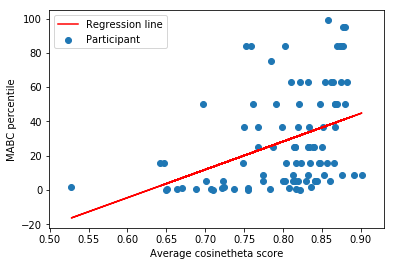

In [39]:
# ID is unique per child
# the higher the costheta score, the better the performance
# mabc_percentile_score is the label associated with the motor skills, again the higher the better

# create a dataframe containing this data
subdata = rr_data[['ID', 'costheta', 'mabc_percentile_score']]

# create a set of all unique children
children_ids = set(subdata['ID'])

# create a dictionary containing children id's as key and a tuple containing costheta and mabc_percentile as val
subdata_dictionary = {}
for child_id in children_ids:
    avg_ct = subdata.loc[subdata['ID'] == child_id]['costheta'].mean()
    mabc_perc = subdata.loc[subdata['ID'] == child_id]['mabc_percentile_score'].mean()
    subdata_dictionary[child_id] = (avg_ct, mabc_perc)
#     print("Child: {} has an avarage costheta score of {} and an MABC percentile equal to {}.".format(child_id, round(avg_ct, 5), round(mabc_perc, 3)))

avg_ct, mabc = dict_to_x_y(subdata_dictionary)
slope, intercept, r_value, p_value, std_err = stats.linregress(avg_ct, mabc)
avg_ct_slope = [i * slope for i in avg_ct]

# scatter plot with mabc
plt.scatter(avg_ct, mabc, label='Participant')
plt.plot(avg_ct, intercept + avg_ct_slope, 'r', label='Regression line')
plt.xlabel("Average cosinetheta score")
plt.ylabel("MABC percentile")
plt.legend()


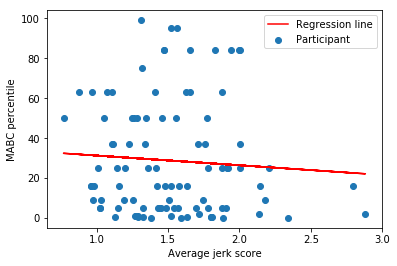

In [42]:
# ID is unique per child
# the higher the costheta score, the better the performance
# mabc_percentile_score is the label associated with the motor skills, again the higher the better

# create a dataframe containing this data
subdata_jerk = rr_data[['ID', 'jerk', 'mabc_percentile_score']]

# create a dictionary containing children id's as key and a tuple containing costheta and mabc_percentile as val
subdata_jerk_dictionary = {}
for child_id in children_ids:
    avg_jerk = subdata_jerk.loc[subdata['ID'] == child_id]['jerk'].mean()
    mabc_perc = subdata_jerk.loc[subdata['ID'] == child_id]['mabc_percentile_score'].mean()
    subdata_jerk_dictionary[child_id] = (avg_jerk, mabc_perc)
#     print("Child: {} has an avarage costheta score of {} and an MABC percentile equal to {}.".format(child_id, round(avg_ct, 5), round(mabc_perc, 3)))

avg_jerk, mabc = dict_to_x_y(subdata_jerk_dictionary)
slope, intercept, r_value, p_value, std_err = stats.linregress(avg_jerk, mabc)
avg_jerk_slope = [i * slope for i in avg_jerk]

# scatter plot with mabc
plt.scatter(avg_jerk, mabc, label='Participant')
plt.plot(avg_jerk, intercept + avg_jerk_slope, 'r', label='Regression line')
plt.xlabel("Average jerk score")
plt.ylabel("MABC percentile")
plt.legend()


## Tijd fixen

In [ ]:
rr_data